<a href="https://colab.research.google.com/github/tijlk/cats_vs_dogs/blob/master/Cats_vs_Dogs_Workshop_Solutions.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Transfer Learning in image recognition - Cats vs. Dogs


# Introduction


## Cats vs. Dogs

Training dataset of 25,000 images (50% cats, 50% dogs).

Competition on Kaggle: [Dogs vs. Cats Redux Kernels Edition](https://www.kaggle.com/c/dogs-vs-cats-redux-kernels-edition)

![](https://cdn-images-1.medium.com/max/1600/1*R-ItxBW2SWarITBKe7HZuA.gif)



## References

* Guide on [transfer learning on medium.com](https://towardsdatascience.com/a-comprehensive-hands-on-guide-to-transfer-learning-with-real-world-applications-in-deep-learning-212bf3b2f27a)
* 'Deep Learning with Python' by Francois Chollet ([pdf](http://www.google.com/search?q=deep+learning+with+python+francois+chollet+pdf), [Amazon](https://www.amazon.com/Deep-Learning-Python-Francois-Chollet/dp/1617294438))



## Setting up Google Colab

*   First of all, it's probably a good idea to save this notebook in your Google Drive. To do that, go to File and click on 'Save a copy in Drive'. Otherwise, you might lose your results if you're not careful.
*   You want to use GPU's, so make sure to select a GPU runtime. Go to 'Runtime' -> 'Change runtime type'. Select 'GPU' as Hardware accelarator and click on 'Save'.

## Setting up the Kaggle API

In [0]:
import os
os.environ["KAGGLE_USERNAME"] = "uniteds"
os.environ["KAGGLE_KEY"] = "e2cc23b4870d3b069e2f8bf9d159847d"

## Downloading the data

Download the dataset. It contains a `train.zip` with 25,000 images, and a `test.zip` with 12,500 images that you can use to score and submit to the Kaggle competition. We won't use the test.zip file. This should only take about a minute. It's downloading to the Google servers, not to your local drive.

In [2]:
!kaggle competitions download -c dogs-vs-cats-redux-kernels-edition
!unzip -q -o train.zip
!unzip -q -o test.zip
!chmod 644 *.csv

test.zip: Skipping, found more recently modified local copy (use --force to force download)
train.zip: Skipping, found more recently modified local copy (use --force to force download)
sample_submission.csv: Skipping, found more recently modified local copy (use --force to force download)


## Packages

In [3]:
!pip install wget
import wget
import cv2, glob, keras, os, random, shutil
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

try:
    from google.colab.patches import cv2_imshow
except ModuleNotFoundError:
    def cv2_imshow(img):
        plt.imshow(img)
        plt.show()
    
from keras import models, layers, regularizers, optimizers
from keras import backend as K
from keras.applications import VGG16
from keras.callbacks import ModelCheckpoint, Callback, EarlyStopping
from keras.layers import Input, Dropout, Flatten, Convolution2D, Conv2D, \
    MaxPooling2D, Dense, Activation
from keras.layers.normalization import BatchNormalization
from keras.models import Sequential, load_model
from keras.optimizers import RMSprop
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator
from keras.utils import np_utils
from matplotlib import ticker
from numbers import Number
from sklearn.model_selection import train_test_split
from tqdm import tqdm, tqdm_notebook

%matplotlib inline 

Using TensorFlow backend.


# Preparing the Data


## Putting the data into folders

The data is now available as `.jpg` images. We need to translate it to floating point numbers in order for Keras to be able to work with it. We will be using the `flow_from_directory` method from Keras for this, which does all the translation from .jpg to integers and then to floating points for us.

To be able to use this method, we need to put the files in a certain directory structure as shown below.

See also [this tutorial on medium.com](https://medium.com/@vijayabhaskar96/tutorial-image-classification-with-keras-flow-from-directory-and-generators-95f75ebe5720).

![alt text](https://cdn-images-1.medium.com/max/1000/1*HpvpA9pBJXKxaPCl5tKnLg.jpeg)

In [0]:
def gather_training_images(n_cats_train=1000, n_cats_validation=500):
    root_dir = ''
    original_train_dir = os.path.join(root_dir, 'train')
    original_test_dir = os.path.join(root_dir, 'test')
    base_dir = os.path.join(root_dir, 'cats_and_dogs_small')

    # Directory with our training cat pictures
    train_dir = os.path.join(base_dir, 'train')
    train_cats_dir = os.path.join(train_dir, 'cats')
    train_dogs_dir = os.path.join(train_dir, 'dogs')

    # Directory with our validation cat pictures
    validation_dir = os.path.join(base_dir, 'validation')
    validation_cats_dir = os.path.join(validation_dir, 'cats')
    validation_dogs_dir = os.path.join(validation_dir, 'dogs')

    test_base_dir = os.path.join(base_dir, 'test')
    test_dir = os.path.join(test_base_dir, 'images')

    dirs = [base_dir, train_dir, train_cats_dir, train_dogs_dir, validation_dir, 
            validation_cats_dir, validation_dogs_dir, test_base_dir, test_dir]
    # Clean up the directories if they already exist
    for dir in dirs:
        try:
            shutil.rmtree(dir)
        except FileNotFoundError:
            pass
        os.mkdir(dir)
        
    cat_train_files = [file for file in os.listdir(original_train_dir) if 'cat' in file]
    dog_train_files = [file for file in os.listdir(original_train_dir) if 'dog' in file]

    # Split into training and validation sets
    train_cats, validation_cats = train_test_split(cat_train_files, train_size=n_cats_train,
                                                   test_size=n_cats_validation, random_state=42)
    train_dogs, validation_dogs = train_test_split(dog_train_files, train_size=n_cats_train,
                                                   test_size=n_cats_validation, random_state=42)

    # Copy training and validation images
    grps = [{'target_dir': train_cats_dir, 'files': train_cats},
            {'target_dir': train_dogs_dir, 'files': train_dogs},
            {'target_dir': validation_cats_dir, 'files': validation_cats},
            {'target_dir': validation_dogs_dir, 'files': validation_dogs}]
    for grp in grps:
        for fname in grp['files']:
            src = os.path.join(original_train_dir, fname)
            dst = os.path.join(grp['target_dir'], fname)
            shutil.copyfile(src, dst)

    # Copy test images
    for fname in [f for f in os.listdir('test')]:
        src = os.path.join(os.path.join(root_dir, 'test'), fname)
        spl = fname.split('.')
        dst = os.path.join(test_dir, f"{int(spl[0]):05d}.jpg")
        shutil.copyfile(src, dst)
        
    for dir in ['cats_and_dogs_small/train/cats',
                'cats_and_dogs_small/train/dogs',
                'cats_and_dogs_small/validation/cats',
                'cats_and_dogs_small/validation/dogs',
                'cats_and_dogs_small/test/images']:
        print(f"Directory {dir} contains {len(os.listdir(dir))} files.")
    
    return train_dir, validation_dir, test_base_dir

In [5]:
train_dir, validation_dir, test_base_dir = \
    gather_training_images(n_cats_train=500, n_cats_validation=250)

Directory cats_and_dogs_small/train/cats contains 500 files.
Directory cats_and_dogs_small/train/dogs contains 500 files.
Directory cats_and_dogs_small/validation/cats contains 250 files.
Directory cats_and_dogs_small/validation/dogs contains 250 files.
Directory cats_and_dogs_small/test/images contains 12500 files.


## Creating data generators using `flow_from_directory`

In [0]:
def get_data_generator(train_dir, validation_dir, test_base_dir, size=150,
                       batch_size=20):
    """Returns a generator for batches of training data and
    a generator for batches of validation data."""
    # All images will be rescaled by 1./255
    validation_datagen = ImageDataGenerator(rescale=1./255)
    test_datagen = ImageDataGenerator(rescale=1./255)
    train_datagen = ImageDataGenerator(rescale=1./255)
        
    # Point the generators to the right folders and define the batch size
    # and target size
    train_generator = train_datagen.flow_from_directory(
            train_dir,  # This is the target directory
            target_size=(size, size),  # All images will be resized to 150x150
            batch_size=batch_size,
            # Since we use binary_crossentropy loss, we need binary labels
            class_mode='binary')
    validation_generator = validation_datagen.flow_from_directory(
            validation_dir,
            target_size=(size, size),
            batch_size=batch_size,
            class_mode='binary')
    test_generator = test_datagen.flow_from_directory(
            test_base_dir,
            target_size=(size, size),
            batch_size=1,
            shuffle=False,
            class_mode=None)
    
    for data_batch, labels_batch in train_generator:
        print(f'\ndata batch shape: {data_batch.shape}')
        print(f'labels batch shape: {labels_batch.shape}')
        break

    return train_generator, validation_generator, test_generator

In [7]:
train_gen, valid_gen, test_gen = get_data_generator(
    train_dir, validation_dir, test_base_dir, size=100)

Found 1000 images belonging to 2 classes.
Found 500 images belonging to 2 classes.
Found 12500 images belonging to 1 classes.

data batch shape: (20, 100, 100, 3)
labels batch shape: (20,)


So, the `train_gen` generator yields both a batch of 20 images and a batch of 20 labels. Let's show one batch of images:

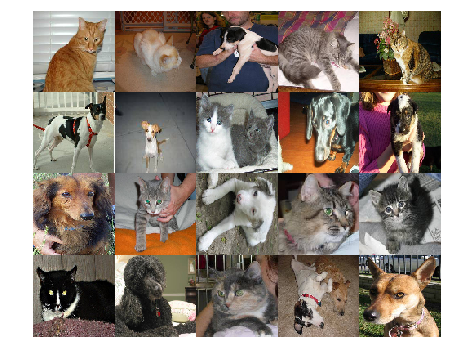

In [8]:
for data_batch, labels_batch in train_gen:
    size = 100
    n_cols, n_rows = (5, 4)
    display_grid = np.zeros((size * n_rows, n_cols * size, 3))

    # We'll tile each filter into this big horizontal grid
    i = 0
    for col in range(n_cols):
        for row in range(n_rows):
            display_grid[row * size : (row + 1) * size,
                         col * size : (col + 1) * size, :] = data_batch[i,:]
            i += 1

    # Display the grid
    plt.figure(figsize=(1.5/size * display_grid.shape[1],
                        1.5/size * display_grid.shape[0]))
    plt.imshow(display_grid)
    plt.axis('off')
    break

# Convolutional neural networks

A convolutional neural network consists of two parts: a convolutional part and a classification (or regression) part.

![](https://cdn-media-1.freecodecamp.org/images/dobVrh3SGyqQraM2ogi-P3VK2K-LFsBm7RLO)



### Convolution

The term convolution refers to the mathematical combination of two functions to produce a third function. It merges two sets of information sliding over each other. In the case of a CNN, the convolution is performed on the input data with the use of a filter or kernel (these terms are used interchangeably) to then produce a feature map.

![](https://cdn-media-1.freecodecamp.org/images/d0ufdQE7LHA43cdSrVefw2I9DFceYMixqoZJ)

The fundamental difference between a dense layer and a convolutional layer is that a dense layer learns global patterns in the input space, whereas a convolutional layer learns local patterns (of size 3x3 or 5x5 pixels usually). This means that:
* the patterns a convolutional layer learns are *translation invariant*
* multiple convolutionaly layers stacked on top of each other can learn *spatial hierarchies of patterns*. The lower layers learn local patterns such as edges, while upper layers will learn increasingly abstract and complex visual concepts such as ears and eyes.



### Classification

The second part of the architecture then takes these higher level *features* and uses them in a couple of fully connected (dense) layers to classify the image as for example a cat or a dog.


# Training our CNN's



## Our first example network

Let's have a look at a very simple but working example of a convolutional neural network that can distinguish cats from dogs:

In [9]:
model = models.Sequential()

Adding the first convolutional layer with 32 filters of 3x3 pixels with **ReLU activation**. Why ReLU? 

* Easy to compute
* Converges faster than sigmoid or tanh because it doesn't suffer from vanishing gradients
* Is sparsely activated, which prevents overfitting

![](https://cdn-images-1.medium.com/max/800/1*DfMRHwxY1gyyDmrIAd-gjQ.png)

In [10]:
model.add(layers.Conv2D(32, (3, 3), activation='relu',
                        input_shape=(size, size, 3)))

----

### QUESTION 1
_How many parameters are going to be trained for this first convolutional layer?_

**ANSWER:**

We say that the filters are of size 3x3, but that is not really the case actually. Because the filters are sliding over the full 3D-tensor of the input. So if the input image has 3 channels, the filters will actually be of size 3x3x3. We have 32 filters, and each filter has a bias node as well, so we actually have (3x3x3+1)*32 parameters to train in the first layer.

In [11]:
print(f"There are {(3*3*3+1)*32:,} parameters to be trained.")

There are 896 parameters to be trained.


----



```
# This is formatted as code
```

The image below shows how the feature map is constructed from each filter sliding over the input image in the first layer.

**Convolution in 3 dimensions**:

![](https://m-alcu.github.io/assets/cntk103d_conv2d_final.gif)

Next, we add a Max Pooling layer. This reduces the dimensionality and prevents overfitting.

![](https://cdn-media-1.freecodecamp.org/images/96HH3r99NwOK818EB9ZdEbVY3zOBOYJE-I8Q)

In [12]:
model.add(layers.MaxPooling2D((2, 2)))

Then we add three more convolutional and max pooling layers, gradually decreasing the width and height of the feature maps and increasing the number of filters in each convolutional layer.

In [0]:
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))


----

### QUESTION 2
_How many parameters are to be trained for the final convolutional layer?_

**Answer:**

In [14]:
print(f"There are {(3*3*128+1)*128:,} parameters to be trained.")

There are 147,584 parameters to be trained.


-----

Finally, we flatten the final feature map into a vector and connect that to two dense layers which will do the final classification of the image. We're doing binary classification, so we use a sigmoid activation function for the final node.

In [0]:
model.add(layers.Flatten())
model.add(layers.Dense(512, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

Finally, you can verify your answers on the two questions using `model.summary()`. The number of parameters for each layer is shown on the right side.

In [16]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 98, 98, 32)        896       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 49, 49, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 47, 47, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 23, 23, 64)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 21, 21, 128)       73856     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 10, 10, 128)       0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 8, 8, 128)        

In [17]:
train_gen, validation_gen, test_gen = \
    get_data_generator(train_dir, validation_dir, test_base_dir, size=100)

Found 1000 images belonging to 2 classes.
Found 500 images belonging to 2 classes.
Found 12500 images belonging to 1 classes.

data batch shape: (20, 100, 100, 3)
labels batch shape: (20,)


### Let's train this thing...

First we compile the model and specify that we use the RMSprop optimizer, binary cross entropy as a loss function and want to measure the accuracy.

In [18]:
model.compile(loss='binary_crossentropy',
              optimizer=optimizers.RMSprop(lr=1e-4),
              metrics=['acc'])



Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Next we first create some helper functions that will make it easier for us to quickly train new models and show results.

* **`train_model`** is a function that trains the model with a given data generator, stores results in a history object and saves the best model to disk as an `.h5` file. Furthermore you can use `early_stopping_patience` to stop the training when the model hasn't improved on the validation set for more than `x` epochs.

In Keras, we can implement **early stopping** as a callback function. Callbacks are functions that can be applied at certain stages of the training process, such as at the end of each epoch. Specifically, in our solution, we included `EarlyStopping(monitor='val_loss', patience=15)` to define that we wanted to monitor the test (validation) loss at each epoch and after the test loss has not improved after fifteen epochs, training is interrupted. However, since we set patience=15, we won’t get the best model, but the model fifteen epochs after the best model. Therefore, optionally, we can include a second operation, `ModelCheckpoint` which saves the model to a file after every checkpoint (which can be useful in case a multi-day training session is interrupted for some reason. Helpful for us, if we set `save_best_only=True` then `ModelCheckpoint` will only save the best model.

In [0]:
def train_model(model, train_generator, validation_generator, n_epochs=30, 
                filename='cats_and_dogs.h5', early_stopping_patience=None,
                batch_size=20):
    """Fits the model to the training data and monitors accuracy and loss
    on the validation set as well"""
    n_train_images = len(os.listdir(train_dir + '/cats')) * 2
    print(f"Training on {n_train_images} training images. Each epoch has "
          f"{n_train_images // batch_size} batches of {batch_size} images.")
    
    # I'm using early stopping to monitor the validation loss and stop the
    # training when the validation loss hasn't improved for a number of epochs
    # I also keep track of the model with the best validation loss using the
    # modelcheckpoint callback.
    if early_stopping_patience is not None:
        es = EarlyStopping(monitor='val_acc', mode='max', 
                           verbose=1, patience=early_stopping_patience)
        mc = ModelCheckpoint(filename, monitor='val_acc', mode='max',
                             verbose=0, save_best_only=True)
        callbacks = [es, mc]
    else:
        callbacks = None
        
    # Fit the model
    history = model.fit_generator(
        train_generator,
        steps_per_epoch=n_train_images // batch_size,
        epochs=n_epochs,
        validation_data=validation_generator,
        validation_steps=n_train_images // batch_size // 2,
        callbacks=callbacks
    )
    
    # Save the model if it wasn't already saved with the modelcheckpoints
    if early_stopping_patience is None:
        model.save(filename)
        
    # Return the history so we can plot the results.
    return history

* **`evaluate_model`** shows accuracy and loss values for training and validation sets.

In [0]:
def evaluate_model(model, train_gen, validation_gen):
    """Evaluate a model on the training, validation and test sets and
    show the accuracy and loss for each"""
    print("Best model:")
    # Evaluate the model on each of the datasets
    tr_r = model.evaluate_generator(train_gen, steps=len(train_gen))
    va_r = model.evaluate_generator(validation_gen, steps=len(validation_gen))
    
    # See https://blog.henryhhammond.com/pandas-formatting-snippets/
    def as_percent(v, precision='0.1'):  
        """Convert number to percentage string."""
        if isinstance(v, Number):
            return "{{:{}%}}".format(precision).format(v)
        else:
            raise TypeError("Numeric type required")

    # Reformat the results into a dataframe
    df = pd.DataFrame([tr_r, va_r])
    df.index = ['Train', 'Validation']
    df.columns = ['Loss', 'Accuracy_float']
    df['Accuracy'] = df['Accuracy_float'].apply(as_percent)
    df = df[['Loss', 'Accuracy']]
    df = df.round({"Loss":3})
    return df

* **`plot_accuracy`** plots the accuracy and loss of the training and validations sets through the epochs.*italicized text*

In [0]:
def plot_accuracy(history):
    """Plots the accuracy and loss of the training and validation sets."""
    acc = history.history['acc']
    val_acc = history.history['val_acc']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = range(len(acc))
    plt.plot(epochs, acc, 'bo', label='Training acc')
    plt.plot(epochs, val_acc, 'b', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.legend()
    plt.figure()
    plt.plot(epochs, loss, 'bo', label='Training loss')
    plt.plot(epochs, val_loss, 'b', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()
    plt.show()

* **`show_example_predictions`** shows predictions on some sample images, as well as some predictions for which it is unsure.

In [0]:
def show_example_predictions(model):
    test_gen.reset()
    print("-"*60+"\nMy prediction on some random cats and dogs:\n")
    for i in range(0,5):
        img = test_gen.next()
        pred = model.predict(img)[0]
        if pred >= 0.5: 
            print('I am {:.0%} sure this is a Dog'.format(pred[0]))
        else: 
            print('I am {:.0%} sure this is a Cat'.format(1-pred[0]))
        cv2_imshow(img[0]*255)
        plt.show()
        print("")

    i = 1
    j = 0
    print("-"*60+"\nSome images for which I'm not so sure:\n")
    while i <= 5:
        img = test_gen.next()
        pred = model.predict(img)[0]
        if pred <= 0.8 and pred >= 0.2:
            if pred >= 0.5: 
                print('I am {:.0%} sure this is a Dog'.format(pred[0]))
            else: 
                print('I am {:.0%} sure this is a Cat'.format(1-pred[0]))
            cv2_imshow(img[0]*255)
            plt.show()
            print("")
            i += 1
        else:
            j += 1
            if j >= 10000:
                break
            pass

In [23]:
history = train_model(model, train_gen, validation_gen, n_epochs=15)

Training on 1000 training images. Each epoch has 50 batches of 20 images.

Epoch 1/15
50/50 [==============================] - 6s 129ms/step - loss: 0.6944 - acc: 0.5080 - val_loss: 0.6866 - val_acc: 0.5120
Epoch 2/15
50/50 [==============================] - 4s 86ms/step - loss: 0.6810 - acc: 0.5660 - val_loss: 0.6754 - val_acc: 0.5840
Epoch 3/15
50/50 [==============================] - 4s 84ms/step - loss: 0.6579 - acc: 0.6230 - val_loss: 0.6592 - val_acc: 0.6040
Epoch 4/15
50/50 [==============================] - 4s 85ms/step - loss: 0.6337 - acc: 0.6590 - val_loss: 0.6551 - val_acc: 0.5860
Epoch 5/15
50/50 [==============================] - 4s 85ms/step - loss: 0.6197 - acc: 0.6480 - val_loss: 0.7914 - val_acc: 0.5040
Epoch 6/15
50/50 [==============================] - 4s 86ms/step - loss: 0.6012 - acc: 0.6760 - val_loss: 0.6809 - val_acc: 0.5800
Epoch 7/15
50/50 [==============================] - 4s 84ms/step - loss: 0.5755 - acc: 0.7040 - val_loss: 0.6772 - val_acc: 0.5920
Epoch 8

In [24]:
evaluate_model(model, train_gen, validation_gen)

Best model:


,Loss,Accuracy
Train,0.349,85.7%
Validation,0.622,67.8%


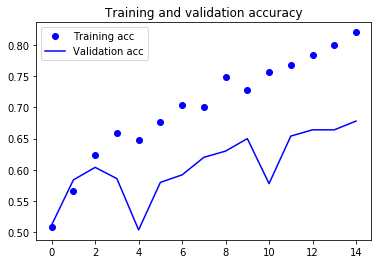

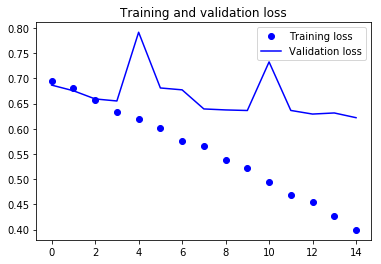

In [25]:
plot_accuracy(history)

------------------------------------------------------------
My prediction on some random cats and dogs:

I am 59% sure this is a Cat


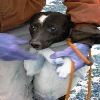


I am 77% sure this is a Dog


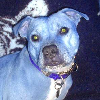


I am 51% sure this is a Dog


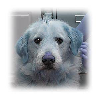


I am 98% sure this is a Dog


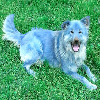


I am 57% sure this is a Dog


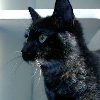


------------------------------------------------------------
Some images for which I'm not so sure:

I am 62% sure this is a Cat


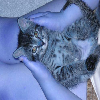


I am 74% sure this is a Cat


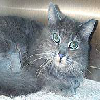


I am 72% sure this is a Cat


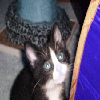


I am 66% sure this is a Cat


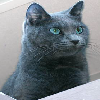


I am 70% sure this is a Dog


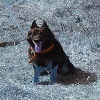

In [26]:
show_example_predictions(model)

Clearly this model completely overfitted on the training set. Let's try to reduce this with **data augmentation**.

## Using data augmentation

The `ImageDataGenerator` allows us to *augment* each image each time it is shown to the network. So instead of training on the same image of a dog standing on a table each epoch, the image of the dog standing on the table will be slightly different in each epoch.

There are a number of augmentations that can be applied, such as:

* rotation
* width and height shifting
* brightness
* shear
* zoom
* horizontal and/or vertical flipping
* ...

So let's adjust our `get_data_generator` function to make use of this.

-------

### EXERCISE 1: Data augmentation
1. _Implement data augmentation in the copy of the `get_data_generator` function below so that overfitting in the training process can be reduced. Use Google._
2. _Then train the same model as we did before, but using data augmentation and check whether the model now performs better._

-------

In [0]:
def get_data_generator(train_dir, validation_dir, test_base_dir, 
                       use_augmentation=True, size=150, batch_size=20):
    """Returns a generator for batches of training data and
    a generator for batches of validation data."""
    # All images will be rescaled by 1./255
    validation_datagen = ImageDataGenerator(rescale=1./255)
    test_datagen = ImageDataGenerator(rescale=1./255)

    # If we want data augmentation, we provide ranges of adjustments
    # that can be done on the training data to generatre 'fake' images
    # to train on.
    # Note that the validation data should not be augmented!
    if use_augmentation:
        print("Using data augmentation...")
        train_datagen = ImageDataGenerator(
            rescale=1./255,
            rotation_range=40,
            width_shift_range=0.2,
            height_shift_range=0.2,
            brightness_range=[0.6, 1.4],
            shear_range=20,
            zoom_range=0.2,
            horizontal_flip=True,
            fill_mode='reflect'
        )
    else:
        train_datagen = ImageDataGenerator(rescale=1./255)
        
    # Point the generators to the right folders and define the batch size
    # and target size
    train_generator = train_datagen.flow_from_directory(
            train_dir,  # This is the target directory
            target_size=(size, size),  # All images will be resized to 150x150
            batch_size=batch_size,
            # Since we use binary_crossentropy loss, we need binary labels
            class_mode='binary')
    validation_generator = validation_datagen.flow_from_directory(
            validation_dir,
            target_size=(size, size),
            batch_size=batch_size,
            class_mode='binary')
    test_generator = test_datagen.flow_from_directory(
            test_base_dir,
            target_size=(size, size),
            batch_size=1,
            shuffle=False,
            class_mode=None)
    
    for data_batch, labels_batch in train_generator:
        print(f'\ndata batch shape: {data_batch.shape}')
        print(f'labels batch shape: {labels_batch.shape}')
        break

    return train_generator, validation_generator, test_generator

Let's have a look at what these augmentations do on a single image. Don't pay too much attention to this code. It's not very relevant.

### Training with data augmentation

So with this new `get_data_generator` function, we basically run the same code again, being careful to recreate the network from scratch so we don't accidentally start updating from an already trained model.

In [28]:
model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), activation='relu',
                        input_shape=(size, size, 3)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Flatten())
model.add(layers.Dense(512, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy',
              optimizer=optimizers.RMSprop(lr=1e-4),
              metrics=['acc'])
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_5 (Conv2D)            (None, 98, 98, 32)        896       
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 49, 49, 32)        0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 47, 47, 64)        18496     
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 23, 23, 64)        0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 21, 21, 128)       73856     
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 10, 10, 128)       0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 8, 8, 128)        

In [29]:
train_gen, validation_gen, test_gen = \
    get_data_generator(train_dir, validation_dir, test_base_dir, size=100)

history = train_model(model, train_gen, validation_gen, n_epochs=15)

Using data augmentation...
Found 1000 images belonging to 2 classes.
Found 500 images belonging to 2 classes.
Found 12500 images belonging to 1 classes.

data batch shape: (20, 100, 100, 3)
labels batch shape: (20,)
Training on 1000 training images. Each epoch has 50 batches of 20 images.
Epoch 1/15
50/50 [==============================] - 8s 168ms/step - loss: 0.6949 - acc: 0.5040 - val_loss: 0.6947 - val_acc: 0.5000
Epoch 2/15
50/50 [==============================] - 7s 147ms/step - loss: 0.6907 - acc: 0.5160 - val_loss: 0.6849 - val_acc: 0.5360
Epoch 3/15
50/50 [==============================] - 7s 146ms/step - loss: 0.6845 - acc: 0.5410 - val_loss: 0.6783 - val_acc: 0.5700
Epoch 4/15
50/50 [==============================] - 7s 146ms/step - loss: 0.6776 - acc: 0.5660 - val_loss: 0.6655 - val_acc: 0.6120
Epoch 5/15
50/50 [==============================] - 7s 147ms/step - loss: 0.6635 - acc: 0.6090 - val_loss: 0.6633 - val_acc: 0.5960
Epoch 6/15
50/50 [==============================] 

Best model:


,Loss,Accuracy
Train,0.654,61.5%
Validation,0.749,53.8%


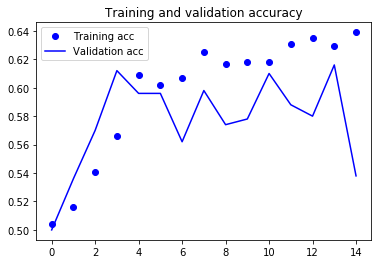

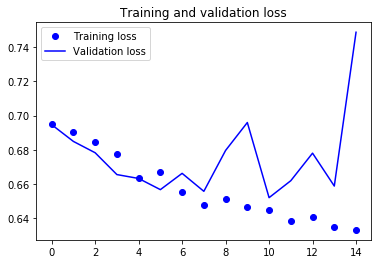

------------------------------------------------------------
My prediction on some random cats and dogs:

I am 64% sure this is a Dog


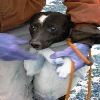


I am 76% sure this is a Dog


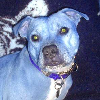


I am 69% sure this is a Dog


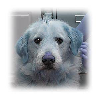


I am 90% sure this is a Dog


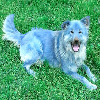


I am 56% sure this is a Dog


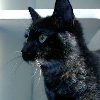


------------------------------------------------------------
Some images for which I'm not so sure:

I am 74% sure this is a Dog


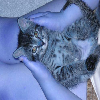


I am 76% sure this is a Dog


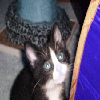


I am 66% sure this is a Dog


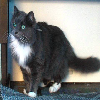


I am 57% sure this is a Cat


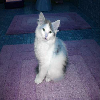


I am 66% sure this is a Dog


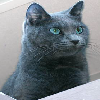

In [30]:
display(evaluate_model(model, train_gen, validation_gen))
plot_accuracy(history)
show_example_predictions(model)

# Transfer Learning


## Using transfer learning for feature extraction

![](https://miro.medium.com/max/960/1*Ww3AMxZeoiB84GVSRBr4Bw.png)

> Transfer learning is the idea of overcoming the isolated learning paradigm and utilizing knowledge acquired for one task to solve related ones.



### VGG16

VGG16 is a convolutional neural network model achieving 92.7% top-5 test accuracy in ImageNet, which is a dataset of over 14 million images belonging to 1000 classes.

It consists of five max pooling layers with two or three convolutional layers before each max pooling layer.

![](https://neurohive.io/wp-content/uploads/2018/11/vgg16-neural-network.jpg)

It uses filters of 3x3 pixels with a padding of 1 pixel to keep the spatial resolution the same after convolution.

### Replace the dense layers with a new classifier
![swapping FC classifiers](https://s3.amazonaws.com/book.keras.io/img/ch5/swapping_fc_classifier.png)


----

### QUESTION 3
_How can I input images of 150x150 pixels into this upgraded VGG16 network?_

_**ANSWER:**_

It's good to note that **the size of the input image is irrelevant to the number of parameters in the convolutional base of the network**. When you change the size of the input image, only the size of the feature maps change, and the size of the dense layers on top of the convolutional layers. The number of parameters in the convolutional layers are only dependent on the number of channels or filter and the size of the filters.

That is why you can use a pretrained network on images of basically any size. Let's check this by loading the VGG16 network with different input_shapes and checking the `model.summary()` for the number of parameters.

----

In [31]:
conv_base = VGG16(weights='imagenet',
                  include_top=False,
                  input_shape=(224, 224, 3))

conv_base.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

In [32]:
conv_base = VGG16(weights='imagenet',
                  include_top=False,
                  input_shape=(32, 32, 3))

conv_base.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 32, 32, 3)         0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 32, 32, 64)        1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 32, 32, 64)        36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 16, 16, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 16, 16, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 16, 16, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 8, 8, 128)         0     

14.7 million parameters in both cases. But different feature map sizes of course.

In [0]:
class DLModel:
    def __init__(self, l2=None, verbose=True, size=100,
                 use_augmentation=True, weights='imagenet', use_dropout=False):
        K.clear_session()
        self.verbose = verbose
        if l2 is not None:
            self.regularizer = regularizers.l2(l2)
        else:
            self.regularizer = None
        self.model = models.Sequential()
        self.conv_base = VGG16(weights=weights, include_top=False,
                               input_shape=(size, size, 3))
        self.model.add(self.conv_base)
        self.model.add(layers.Flatten())
        if use_dropout:
            self.model.add(layers.Dropout(0.5))
        self.model.add(layers.Dense(512, activation='relu', 
                                    kernel_regularizer=self.regularizer))
        if use_dropout:
            self.model.add(layers.Dropout(0.5))
        self.model.add(layers.Dense(1, activation='sigmoid'))
        self.train_gen, self.validation_gen, self.test_gen = \
            get_data_generator(train_dir, validation_dir, test_base_dir,
                               size=size, use_augmentation=use_augmentation)
        self.unfreeze_layers(n=0)
        self.history = None
    
    def unfreeze_layers(self, n=0):
        if self.verbose:
            print('Current nr. of trainable elements:',
                len(self.model.trainable_weights))
        for i, layer in enumerate(self.conv_base.layers):
            if i < len(self.conv_base.layers) - n:
                layer.trainable = False
            else:
                layer.trainable = True
        if self.verbose:
            print('Nr. of trainable elements after adjustments:', 
                len(self.model.trainable_weights))
            for layer in self.model.trainable_weights:
                print(f"    {layer}")
                
    def compile_model(self, learning_rate=1e-4):
        self.model.compile(loss='binary_crossentropy',
                  optimizer=optimizers.RMSprop(lr=learning_rate),
                  metrics=['acc'])
        if self.verbose:
            self.model.summary()
        
    def train(self, early_stopping_patience=15, filename='cats_dogs_model.h5', 
              n_epochs=100, learning_rate=1e-4):
        self.compile_model(learning_rate=learning_rate)
        history = train_model(self.model, self.train_gen, self.validation_gen, 
                              n_epochs=n_epochs, filename=filename,
                              early_stopping_patience=early_stopping_patience)
        # Reload the best model
        self.model = load_model(filename)
        self.conv_base = self.model.layers[0]
        self.history = history
    
    def evaluate(self):
        display(evaluate_model(self.model, self.train_gen, 
                               self.validation_gen))
        
    def plot_accuracy(self):
        if self.history:
            plot_accuracy(self.history)
        else:
            print("Model hasn't been trained yet!")

    def show_example_predictions(self):
        show_example_predictions(self.model)


Using data augmentation...
Found 1000 images belonging to 2 classes.
Found 500 images belonging to 2 classes.
Found 12500 images belonging to 1 classes.

data batch shape: (20, 100, 100, 3)
labels batch shape: (20,)
Current nr. of trainable elements: 30
Nr. of trainable elements after adjustments: 4
    <tf.Variable 'dense_1/kernel:0' shape=(4608, 256) dtype=float32_ref>
    <tf.Variable 'dense_1/bias:0' shape=(256,) dtype=float32_ref>
    <tf.Variable 'dense_2/kernel:0' shape=(256, 1) dtype=float32_ref>
    <tf.Variable 'dense_2/bias:0' shape=(1,) dtype=float32_ref>
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 3, 3, 512)         14714688  
_________________________________________________________________
flatten_1 (Flatten)          (None, 4608)              0         
_________________________________________________________________
dense_1 

,Loss,Accuracy
Train,0.383,81.7%
Validation,0.324,87.4%


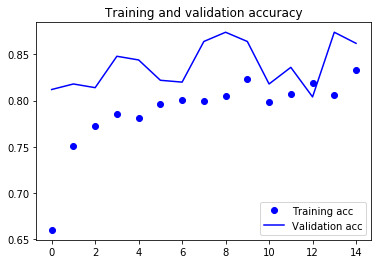

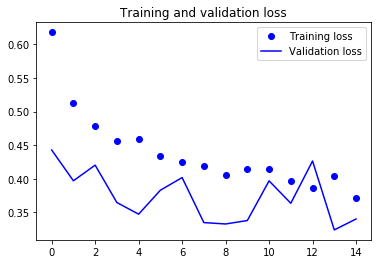

------------------------------------------------------------
My prediction on some random cats and dogs:

I am 92% sure this is a Dog


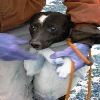


I am 95% sure this is a Dog


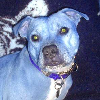


I am 100% sure this is a Dog


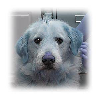


I am 99% sure this is a Dog


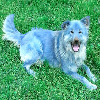


I am 100% sure this is a Cat


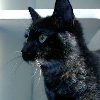


------------------------------------------------------------
Some images for which I'm not so sure:

I am 79% sure this is a Dog


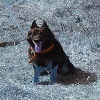


I am 67% sure this is a Dog


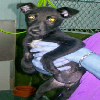


I am 78% sure this is a Cat


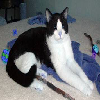


I am 75% sure this is a Dog


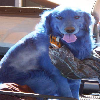


I am 53% sure this is a Dog


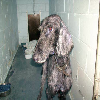

In [34]:
model = DLModel(use_augmentation=True, size=100)
model.train(filename='everything_frozen.h5', n_epochs=15, learning_rate=1e-4)
model.evaluate()
model.plot_accuracy()
model.show_example_predictions()

## Transfer learning with fine-tuning



![fine-tuning VGG16](https://s3.amazonaws.com/book.keras.io/img/ch5/vgg16_fine_tuning.png)

----

### EXERCISE 2: Fine-tuning the last convolutional block

_Come up with and implement a strategy for fine-tuning the last convolutional block of the VGG16-model using only the DLModel class and its methods. In the interest of time, keep it to max. 15 epochs per training run. You might want to think about the order of training and unfreezing the different layers, using dropout, using different learning rates..._

_Save your model (using the `filename=` parameter in the `train` method) as '`4_layers_unfrozen`'._

----

Using data augmentation...
Found 1000 images belonging to 2 classes.
Found 500 images belonging to 2 classes.
Found 12500 images belonging to 1 classes.

data batch shape: (20, 100, 100, 3)
labels batch shape: (20,)
Current nr. of trainable elements: 30
Nr. of trainable elements after adjustments: 4
    <tf.Variable 'dense_1/kernel:0' shape=(4608, 256) dtype=float32_ref>
    <tf.Variable 'dense_1/bias:0' shape=(256,) dtype=float32_ref>
    <tf.Variable 'dense_2/kernel:0' shape=(256, 1) dtype=float32_ref>
    <tf.Variable 'dense_2/bias:0' shape=(1,) dtype=float32_ref>
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 3, 3, 512)         14714688  
_________________________________________________________________
flatten_1 (Flatten)          (None, 4608)              0         
_________________________________________________________________
dense_1 

,Loss,Accuracy
Train,0.431,80.4%
Validation,0.346,86.8%


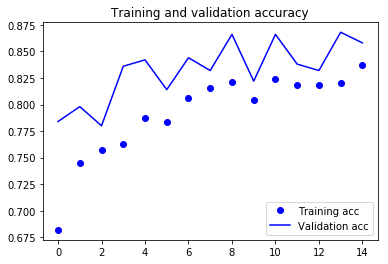

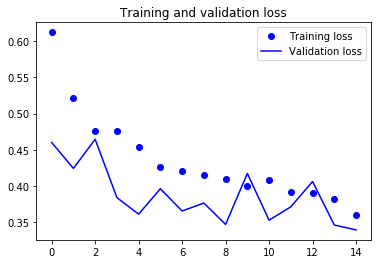

Current nr. of trainable elements: 4
Nr. of trainable elements after adjustments: 6
    <tf.Variable 'block5_conv3_1/kernel:0' shape=(3, 3, 512, 512) dtype=float32_ref>
    <tf.Variable 'block5_conv3_1/bias:0' shape=(512,) dtype=float32_ref>
    <tf.Variable 'dense_1_1/kernel:0' shape=(4608, 256) dtype=float32_ref>
    <tf.Variable 'dense_1_1/bias:0' shape=(256,) dtype=float32_ref>
    <tf.Variable 'dense_2_1/kernel:0' shape=(256, 1) dtype=float32_ref>
    <tf.Variable 'dense_2_1/bias:0' shape=(1,) dtype=float32_ref>
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 3, 3, 512)         14714688  
_________________________________________________________________
flatten_1 (Flatten)          (None, 4608)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 256)               1179

,Loss,Accuracy
Train,0.321,86.2%
Validation,0.340,87.4%


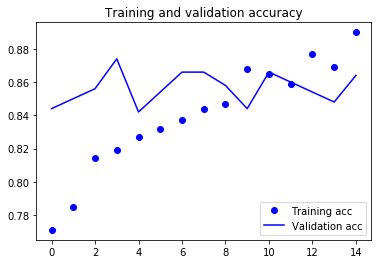

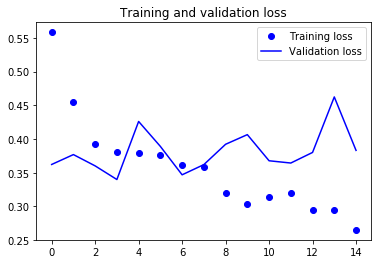

Current nr. of trainable elements: 6
Nr. of trainable elements after adjustments: 8
    <tf.Variable 'block5_conv2_2/kernel:0' shape=(3, 3, 512, 512) dtype=float32_ref>
    <tf.Variable 'block5_conv2_2/bias:0' shape=(512,) dtype=float32_ref>
    <tf.Variable 'block5_conv3_2/kernel:0' shape=(3, 3, 512, 512) dtype=float32_ref>
    <tf.Variable 'block5_conv3_2/bias:0' shape=(512,) dtype=float32_ref>
    <tf.Variable 'dense_1_2/kernel:0' shape=(4608, 256) dtype=float32_ref>
    <tf.Variable 'dense_1_2/bias:0' shape=(256,) dtype=float32_ref>
    <tf.Variable 'dense_2_2/kernel:0' shape=(256, 1) dtype=float32_ref>
    <tf.Variable 'dense_2_2/bias:0' shape=(1,) dtype=float32_ref>
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 3, 3, 512)         14714688  
_________________________________________________________________
flatten_1 (Flatten)          (Non

In [0]:
model = DLModel(use_augmentation=True, size=100)

model.train(n_epochs=15, learning_rate=1e-4)
model.evaluate()
model.plot_accuracy()

# Unfreezing only one layer doesn't help. That would be the max
# pooling layer, which isn't trainable anyway.
model.unfreeze_layers(n=2)
model.train(n_epochs=15, learning_rate=1e-4)
model.evaluate()
model.plot_accuracy()

model.unfreeze_layers(n=3)
model.train(n_epochs=15, learning_rate=5e-5)
model.evaluate()
model.plot_accuracy()

model.unfreeze_layers(n=4)
model.train(n_epochs=15, learning_rate=2e-5, filename='4_layers_unfrozen.h5')
model.evaluate()
model.plot_accuracy()

#model.show_example_predictions()

# Visualising what networks learn

## Seeing activations of each node

In [0]:
model = load_model('4_layers_unfrozen.h5')
model.summary()

In [0]:
img_path = 'train/cat.1700.jpg'

# We preprocess the image into a 4D tensor
img = image.load_img(img_path, target_size=(100, 100))
img_tensor = image.img_to_array(img)
img_tensor = np.expand_dims(img_tensor, axis=0)
# Remember that the model was trained on inputs
# that were preprocessed in the following way:
img_tensor /= 255.

# Its shape is (1, 150, 150, 3)
print(img_tensor.shape)

In [0]:
plt.imshow(img_tensor[0])
plt.show()

In [0]:
# Extracts the outputs of the top 8 layers:
layers_to_show = [3,6,10,14,18] # pooling layers
layer_outputs = [layer.output for i, layer in enumerate(model.layers[0].layers) if i in layers_to_show]
# Creates a model that will return these outputs, given the model input:
activation_model = models.Model(inputs=model.layers[0].get_input_at(0), outputs=layer_outputs)

In [0]:
# This will return a list of 5 Numpy arrays:
# one array per layer activation
activations = activation_model.predict(img_tensor)

In [0]:
first_layer_activation = activations[0]
plt.matshow(first_layer_activation[0, :, :, 3], cmap='viridis')
plt.show()

In [0]:
plt.matshow(first_layer_activation[0, :, :, 30], cmap='viridis')
plt.show()

In [0]:
# These are the names of the layers, so can have them as part of our plot
layer_names = []
for layer in [model.layers[0].layers[i] for i in layers_to_show]:
    layer_names.append(layer.name)

images_per_row = 16

# Now let's display our feature maps
for layer_name, layer_activation in zip(layer_names, activations):
    # This is the number of features in the feature map
    n_features = layer_activation.shape[-1]

    # The feature map has shape (1, size, size, n_features)
    size = layer_activation.shape[1]

    # We will tile the activation channels in this matrix
    n_cols = np.min([n_features // images_per_row, 4])
    display_grid = np.zeros((size * n_cols, images_per_row * size))

    # We'll tile each filter into this big horizontal grid
    for col in range(n_cols):
        for row in range(images_per_row):
            channel_image = layer_activation[0,
                                             :, :,
                                             col * images_per_row + row]
            # Post-process the feature to make it visually palatable
            channel_image -= channel_image.mean()
            channel_image /= channel_image.std()
            channel_image *= 64
            channel_image += 128
            channel_image = np.clip(channel_image, 0, 255).astype('uint8')
            display_grid[col * size : (col + 1) * size,
                         row * size : (row + 1) * size] = channel_image

    # Display the grid
    scale = 1. / size
    plt.figure(figsize=(scale * display_grid.shape[1],
                        scale * display_grid.shape[0]))
    plt.title(layer_name)
    plt.grid(False)
    plt.imshow(display_grid, aspect='auto', cmap='viridis')
    
plt.show()

----

### QUESTION 4

_Why are in the top layers some nodes 'blank'? What does this mean?_

**Answer:** The higher level nodes are detecting more abstract and higher level concepts that are not present in every image. So, activations are just blank when the pattern this node has been trained to detect is just not present in the image. Because we're using ReLU activations, whenever the input of the activation function is below 0, it just returns 0, i.e. a blank image.

----

## Visualising what a given node has learnt to detect

We start with a picture containing random pixels. We apply the network in evaluation mode to this random image, calculate the average activation of a certain feature map in a certain layer from which we then compute the gradients with respect to the input image pixel values. Knowing the gradients for the pixel values we then proceed to update the pixel values in a way that maximizes the average activation of the chosen feature map.

Basically we try to find an image that maximizes the average activation of a certain feature map by performing gradient descent optimization on the pixel values.

### EXERCISE 3: Filter visualisation

_Complete the generate pattern function, so that it initializes a random noise image and through gradient descent optimizes the image such that it activates a given filter as much as possible. Parts missing:_
1. _Initialize the random input image_
2. _Calculate the gradient_
3. _Normalize the gradient_
4. _Adjust the input image accordingly_

In [0]:
def deprocess_image(x):
    # normalize tensor: center on 0., ensure std is 0.1
    x -= x.mean()
    x /= (x.std() + 1e-5)
    x *= 0.1

    # clip to [0, 1]
    x += 0.5
    x = np.clip(x, 0, 1)

    # convert to RGB array
    x *= 255
    x = np.clip(x, 0, 255).astype('uint8')
    return x

In [0]:
def generate_pattern(model, layer_name, filter_index, size=150, steps=40, vgg_layer=True):
    # Initialize the image as a floating point 4D-numpy array filled with 
    # random 'grey' noise (in the 0. to 255 range). Note that once again, we
    # need 4 dimensions rather than 3.
    input_img_data = np.random.random((1, size, size, 3)) * 20 + 128.

    # Build a loss function that maximizes the activation
    # of the nth filter of the layer considered.
    if vgg_layer:
        layer_output = model.layers[0].get_layer(layer_name).output
        loss = K.mean(layer_output[:, :, :, filter_index])
        input_layer = model.layers[0].get_input_at(0)
    else:
        layer_output = model.get_layer(layer_name).output
        loss = K.mean(layer_output[:, filter_index])
        input_layer = model.input

    # Compute the gradients of the input picture with respect to the loss.
    # Use K.gradients for this. Note that the network assumes you're working
    # with 4D-tensors, where the first dimension is the number of images.
    # We only care about the gradients of the first 'image'
    grads = K.gradients(loss, input_layer)[0]

    # Normalize the gradients to prevent gradients from exploding and remain
    # stable.
    normalized_grads = grads / (K.sqrt(K.mean(K.square(grads))) + 1e-5)

    # This function returns the loss and grads given the input picture
    iterate = K.function([input_layer], [loss, normalized_grads])
    
    # Run gradient ascent for 40 steps
    for i in range(steps):
        loss_value, grads_value = iterate([input_img_data])
        
        # Adjust the input image based on the gradients
        input_img_data = input_img_data + grads_value
    
    img = input_img_data[0]

    return deprocess_image(img)

In [0]:
def show_best_activations(model, size=100):
    for layer_name in tqdm_notebook(
            ['block1_conv2', 'block2_conv2', 'block3_conv3', 
             'block4_conv3', 'block5_conv3', 'dense_1']):
        margin = 5
        rows = 2
        columns = 8

        # This a empty (black) image where we will store our results.
        results = np.zeros((rows * size + (rows-1) * margin, columns * size + (columns-1) * margin, 3))
        print(f"Layer {layer_name}")
        for i in tqdm_notebook(range(columns)):  # iterate over the rows of our results grid
            for j in range(rows):  # iterate over the columns of our results grid
                #print(f"Generating image for filter {j + (i * grid_size)} out of in layer {layer_name}...")
                # Generate the pattern for filter `i + (j * 8)` in `layer_name`
                if layer_name == 'dense_1':
                    filter_img = generate_pattern(model, layer_name, j + (i * rows), size=size, vgg_layer=False)
                else:
                    filter_img = generate_pattern(model, layer_name, j + (i * rows), size=size, vgg_layer=True)

                # Put the result in the square `(i, j)` of the results grid
                horizontal_start = i * size + i * margin
                horizontal_end = horizontal_start + size
                vertical_start = j * size + j * margin
                vertical_end = vertical_start + size
                results[vertical_start: vertical_end, horizontal_start: horizontal_end, :] = filter_img

        # Display the results grid
        plt.figure(figsize=(16, 4))
        plt.imshow(results.astype(int))
        plt.show()

In [0]:
show_best_activations(model, size=100)

### More advanced version

[Guide on medium.com](https://towardsdatascience.com/how-to-visualize-convolutional-features-in-40-lines-of-code-70b7d87b0030)

Some impressive looking filters:

![](https://miro.medium.com/max/5176/1*8C49dLMgINot63DvafDD3g.jpeg)

## Visualizing heatmaps of class activation

This allows you to debug why an image was classified the way it was. Can be very useful to detect problems with the model or the data, as in this case where a horse was detected based on a watermark, rather than the horse itself:

![](https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcQaoXmQIdO7Ogv-Cm4ekVtuRMDnHKFg1-4uejqrjylhm5iV4kf4)

In [0]:
model = load_model('4_layers_unfrozen.h5')

In [0]:
def load_img_to_tensor(img_path, size=150):
    # We preprocess the image into a 4D tensor
    img = image.load_img(img_path, target_size=(size, size))
    img_tensor = image.img_to_array(img)
    img_tensor = np.expand_dims(img_tensor, axis=0)

    # Remember that the model was trained on inputs
    # that were preprocessed in the following way:
    img_tensor /= 255.
    
    return img_tensor

In [0]:
def create_heatmap(img, model, best_class, n_filters=512):
    # This is the "african elephant" entry in the prediction vector
    object_output = model.layers[0].get_output_at(0)[:, best_class]

    # The is the output feature map of the `block5_conv3` layer,
    # the last convolutional layer in VGG16
    last_conv_layer_output = model.layers[0].get_layer('block5_conv3').output

    # This is the gradient of the "african elephant" class with regard to
    # the output feature map of `block5_conv3`
    grads = K.gradients(object_output, last_conv_layer_output)[0]

    # This is a vector of shape (512,), where each entry
    # is the mean intensity of the gradient over a specific feature map channel
    pooled_grads = K.mean(grads, axis=(0, 1, 2))

    # This function allows us to access the values of the quantities we just defined:
    # `pooled_grads` and the output feature map of `block5_conv3`,
    # given a sample image
    iterate = K.function([model.layers[0].get_input_at(0)], 
                         [pooled_grads, last_conv_layer_output[0]])

    # These are the values of these two quantities, as Numpy arrays,
    # given our sample image of two elephants
    pooled_grads_value, conv_layer_output_value = iterate([img])

    # We multiply each channel in the feature map array
    # by "how important this channel is" with regard to the elephant class
    for i in range(n_filters):
        conv_layer_output_value[:, :, i] *= pooled_grads_value[i]

    # The channel-wise mean of the resulting feature map
    # is our heatmap of class activation
    heatmap = np.mean(conv_layer_output_value, axis=-1)
    heatmap = np.maximum(heatmap, 0)
    heatmap /= np.max(heatmap)
    return heatmap

In [0]:
def show_heatmap(heatmap):
    plt.matshow(heatmap)
    plt.show()

In [0]:
def superimpose(img_path, heatmap, intensity=0.4):
    # We use cv2 to load the original image
    img = cv2.imread(img_path)

    # We resize the heatmap to have the same size as the original image
    heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0]), interpolation = cv2.INTER_NEAREST)

    # We convert the heatmap to RGB
    heatmap = np.uint8(255 * heatmap)

    # We apply the heatmap to the original image
    heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)

    # 0.4 here is a heatmap intensity factor
    superimposed_img = heatmap * intensity + img

    vis = np.concatenate((img, superimposed_img), axis=1)
    width = 600
    height = int(width / vis.shape[1] * vis.shape[0])
    
    vis_resized = cv2.resize(vis, (width, height))

    # Save the image to disk
    cv2_imshow(vis_resized)

In [0]:
# Take some random images in the training set
imgs = os.listdir('train')
np.random.shuffle(imgs)

for img_file in imgs[:10]:
    # Load an image into a tensor
    img_path = f'train/{img_file}'
    img_tensor = load_img_to_tensor(img_path, size=100)

    # predict whether it is a cat or a dog
    pred = model.predict(img_tensor)[0]
    if pred >= 0.5: 
        print(f'\nI am {pred[0]:.0%} sure this is a Dog')
    else: 
        print(f'\nI am {1-pred[0]:.0%} sure this is a Cat')
    
    # Create and superimpose the heatmap
    heatmap = create_heatmap(img_tensor, model, 0)
    superimpose(img_path, heatmap, intensity=0.6)
    

## Everything combined

In [0]:
def show_max_activation(model, img_url, size=200):

    # Extracts the outputs of the top 8 layers:
    layer_outputs = model.layers[0].layers[17].output
    # Creates a model that will return these outputs, given the model input:
    activation_model = models.Model(inputs=model.layers[0].get_input_at(0), outputs=layer_outputs)
    # We preprocess the image into a 4D tensor
    try:
        img_path = wget.download(img_url)
    except:
        print("ERROR - Please try a different image")
        return
    img = image.load_img(img_path, target_size=(size, size))
    img_tensor = image.img_to_array(img)
    img_tensor = np.expand_dims(img_tensor, axis=0)
    # Remember that the model was trained on inputs
    # that were preprocessed in the following way:
    img_tensor /= 255.

    activations = activation_model.predict(img_tensor)
    mean_act = np.mean(activations,axis=(0,1,2))
    tuples = [(i, v) for i, v in enumerate(list(mean_act))]
    tuples = sorted(tuples, key = lambda x: x[1], reverse=True)
    plt.figure(figsize=(7,5))
    act = plt.plot(mean_act,linewidth=2.)
    most_activated_filters = [i for i, v in tuples[:5]]
    print(f"Most activated filters are {most_activated_filters}")
    extraticks=most_activated_filters
    ax = act[0].axes
    ax.set_xlim(0,500)
    for filter in most_activated_filters:
        plt.axvline(x=filter, color='grey', linestyle='--')
    ax.set_xlabel("feature map")
    ax.set_ylabel("mean activation")
    ax.set_xticks([0,200,400] + extraticks)
    plt.show()

    rows = 1
    columns = 5
    margin = 5
    results = np.zeros((rows * size + (rows-1) * margin, columns * size + (columns-1) * margin, 3))
    for i, good_filter in enumerate(most_activated_filters):
        filter_img = generate_pattern(model, 'block5_conv3', good_filter, size=size, steps=100)
        horizontal_start = i * size + i * margin
        horizontal_end = horizontal_start + size
        results[0: size, horizontal_start: horizontal_end, :] = filter_img
    plt.figure(figsize=(15, 3))
    plt.imshow(results.astype(int))
    plt.show()

    # predict whether it is a cat or a dog
    pred = model.predict(img_tensor)[0]
    if pred >= 0.5: 
        print(f'\nI am {pred[0]:.0%} sure this is a Dog')
    else: 
        print(f'\nI am {1-pred[0]:.0%} sure this is a Cat')
    
    # Create and superimpose the heatmap
    heatmap = create_heatmap(img_tensor, model, 0)
    superimpose(img_path, heatmap, intensity=0.6)

In [0]:
model = load_model('everything_frozen.h5')

In [0]:
show_max_activation(model, 'https://pbs.twimg.com/profile_images/1080545769034108928/CEzHCTpI_400x400.jpg', size=100)

In [0]:
show_max_activation(model, 'https://cdn130.picsart.com/288118701068211.png', size=100)

In [0]:
show_max_activation(model, 'https://hips.hearstapps.com/hmg-prod.s3.amazonaws.com/images/dogs-that-dont-shed-1560974761.jpg', size=100)

In [0]:
show_max_activation(model, 'https://www.quartoknows.com/blog/wp-content/uploads/2017/08/Bengal.png', size=100)

In [0]:
show_max_activation(model, 'https://hips.hearstapps.com/hmg-prod.s3.amazonaws.com/images/kitten-playing-with-toy-mouse-royalty-free-image-590055188-1542816918.jpg', size=100)

-----

### QUESTION 5
_Can you find other pictures online that yield interesting activations?_

-----